
# Quantile-Quantile (Q-Q) Plots for Comparing Forecasts and Observations

## Introduction

A Quantile-Quantile (Q-Q) plot is a graphical tool used to compare two probability distributions by plotting their quantiles against each other.

In forecast verification, Q-Q plots can help us understand how well the distribution of a forecast matches the distribution of observed outcomes. This can be done by calculating quantiles from the forecast data and plotting them against the equivalent observation data. This can reveal systematic biases, such as over-forecasting or under-forecasting, and differences in the spread or shape of the distributions. 

This tutorial will specifically demonstrate the use of the `scores.plotdata.qq` function to compare:
1. GraphCast (a machine learning weather model) forecasts against ERA5 reanalysis data (as observations).
2. IFS (Integrated Forecasting System from ECMWF) HRES (deterministic) forecasts against ERA5 reanalysis data.

We will be using precipitation data for our comparison which is on a 1.5 degrees grid.

In [1]:
import pandas as pd
import xarray as xr
import numpy as np
from scores.plotdata import qq
import plotly.express as px

In [2]:
# It may take around 30 seconds to connect to the cloud storage for the first time.
DATES = pd.date_range("2019-12-30", "2020-01-31")
LEAD_TIME = pd.Timedelta("2d")

era5 = xr.open_zarr(
    "gs://weatherbench2/datasets/era5/1959-2023_01_10-6h-240x121_equiangular_with_poles_conservative.zarr"
)
graphcast = xr.open_zarr(
    "gs://weatherbench2/datasets/graphcast/2020/date_range_2019-11-16_2021-02-01_12_hours-240x121_equiangular_with_poles_conservative.zarr"
)
ifs = xr.open_zarr("gs://weatherbench2/datasets/hres/2016-2022-0012-240x121_equiangular_with_poles_conservative.zarr")

graphcast_precip = (
    graphcast.total_precipitation_24hr.sel(time=DATES, prediction_timedelta=LEAD_TIME).compute() * 1000
)  # convert to mm
ifs_precip = (
    ifs.total_precipitation_24hr.sel(time=DATES, prediction_timedelta=LEAD_TIME).compute() * 1000
)  # convert to mm
era5_precip = era5.total_precipitation_24hr.sel(time=DATES).compute() * 1000  # convert to mm

# Update the time coords in the forecast to match up to the observations
graphcast_precip = graphcast_precip.assign_coords({"time": graphcast_precip.time + LEAD_TIME})
ifs_precip = ifs_precip.assign_coords({"time": ifs_precip.time + LEAD_TIME})

Suppose we care about the behaviour of heavier precipitation. Let's calculate the quantile values of our data for quantiles between 0.9 and 1 and visualise them on a Q-Q plot.

In [3]:
QUANTILES = np.arange(0.9, 1, 0.0001)
ifs_qq = qq(ifs_precip, era5_precip, quantiles=QUANTILES)
graphcast_qq = qq(graphcast_precip, era5_precip, quantiles=QUANTILES)

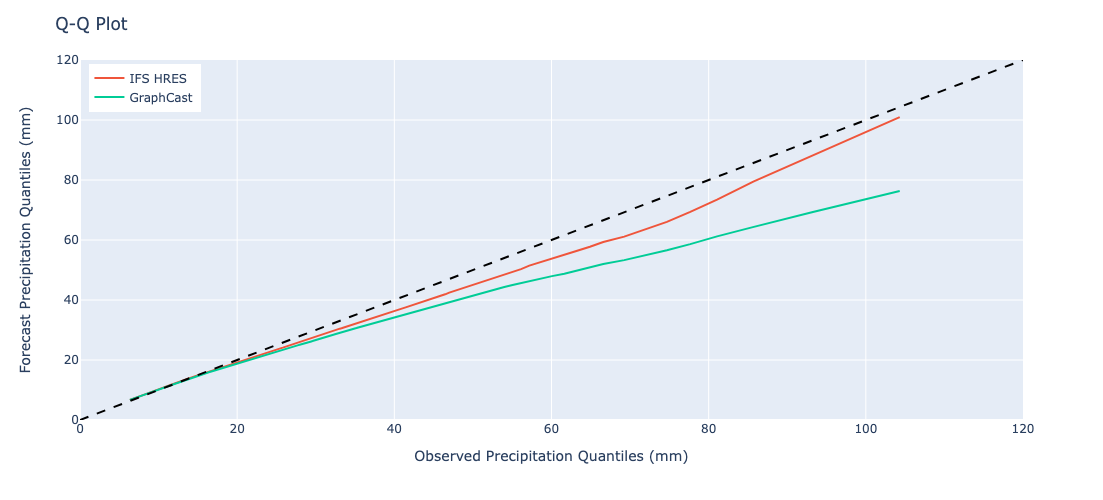

In [6]:
ifs_fcst_qq = ifs_qq.sel(data_source="fcst").values
ifs_obs_qq = ifs_qq.sel(data_source="obs").values

graphcast_fcst_qq = graphcast_qq.sel(data_source="fcst").values
graphcast_obs_qq = graphcast_qq.sel(data_source="obs").values


fig = px.scatter()

# Add IFS forecast and observation data
fig.add_scatter(x=ifs_obs_qq, y=ifs_fcst_qq, mode="lines", name="IFS HRES")

# Add GraphCast forecast and observation data
fig.add_scatter(x=graphcast_obs_qq, y=graphcast_fcst_qq, mode="lines", name="GraphCast")

# Add the diagonal line
fig.add_shape(
    type="line", x0=0, y0=0, x1=120, y1=120, line=dict(color="black", width=2, dash="dash"), name="Reference"
)

# Update layout
fig.update_layout(
    title_text="Q-Q Plot",
    xaxis_title="Observed Precipitation Quantiles (mm)",
    yaxis_title="Forecast Precipitation Quantiles (mm)",
    width=700,
    height=500,
    xaxis=dict(range=[0, 120]),
    yaxis=dict(range=[0, 120])
)
fig.update_layout(legend=dict(x=0.01, y=0.99, xanchor="left", yanchor="top"))
fig.show()

## Interpreting the Q-Q plot
- Points along the black, dashed line indicate that the forecast quantiles match the observed quantiles, suggesting good agreement between the forecast and observations.
- Points above the line suggest that the forecast overestimates the observed values at those quantiles.
- Points below the line suggest underestimation.
- An S-shaped curve might indicate that the forecast distribution has different variance (e.g., less variance if tails are pulled towards the mean, more variance if tails are stretched out).

By examining these plots, you can assess biases and distributional differences between the forecasts and observations.

The IFS Q-Q plot line follows the dashed line reasonably closely. Whereas the GraphCast Q-Q plot line is further below the dashed line which indicates that it does not predict extremes as frequently as they occur in the ERA5 observations (or the IFS HRES).

Let's now create some new Q-Q plots, but this time we will colour the markers based on quantile level.

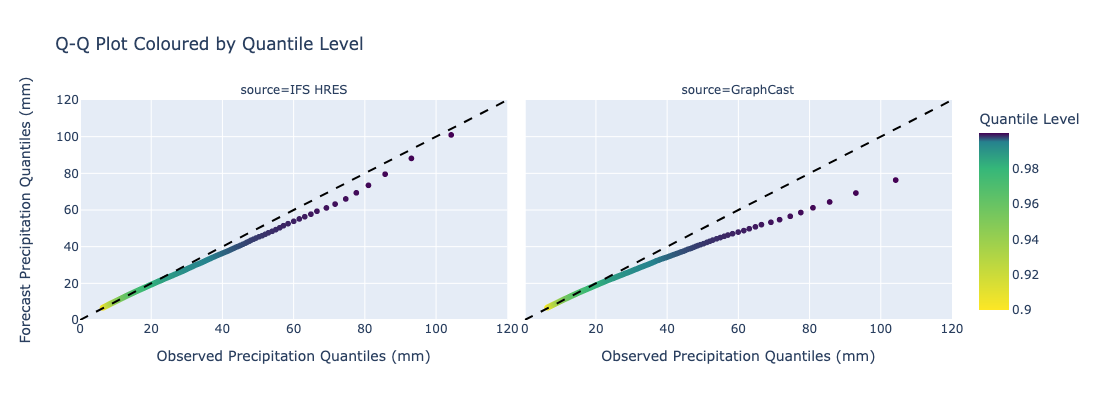

In [7]:
ifs_df = pd.DataFrame({"obs": ifs_obs_qq, "fcst": ifs_fcst_qq, "quantile": QUANTILES, "source": "IFS HRES"})

graphcast_df = pd.DataFrame(
    {"obs": graphcast_obs_qq, "fcst": graphcast_fcst_qq, "quantile": QUANTILES, "source": "GraphCast"}
)
df = pd.concat([ifs_df, graphcast_df])

# Set a custom colour scale to make it easier to visualise the differences
custom_scale = [
    (0.0, px.colors.sequential.Viridis[::-1][0]),
    (0.8, px.colors.sequential.Viridis[::-1][3]),
    (0.95, px.colors.sequential.Viridis[::-1][5]),
    (1.0, px.colors.sequential.Viridis[::-1][-1]),
]

fig = px.scatter(
    df,
    x="obs",
    y="fcst",
    color="quantile",
    facet_col="source",
    color_continuous_scale=custom_scale,
    labels={"obs": "Observed Precipitation Quantiles (mm)", "fcst": "Forecast Precipitation Quantiles (mm)"},
    title="Q-Q Plot Coloured by Quantile Level",
)


fig.add_shape(
    type="line",
    x0=0,
    y0=0,
    x1=120,
    y1=120,
    line=dict(color="black", width=2, dash="dash"),
    xref="x1",
    yref="y1",
)
fig.add_shape(
    type="line",
    x0=0,
    y0=0,
    x1=120,
    y1=120,
    line=dict(color="black", width=2, dash="dash"),
    xref="x2",
    yref="y2",  
)

fig.update_layout(
    width=800, 
    height=400, 
    coloraxis_colorbar=dict(title="Quantile Level"),
    xaxis=dict(range=[0, 120]), 
    yaxis=dict(range=[0, 120]),
    xaxis2=dict(range=[0, 120]),
    yaxis2=dict(range=[0, 120])
)

fig.show()

Quantile-Quantile plots are a powerful visual tool for comparing the distributions of forecasts against observations. They provide insights about:

- **Bias:** Whether a forecast is systematically too high or too low.
- **Dispersion errors:** Whether a forecast distribution is too narrow (under-dispersive) or too wide (over-dispersive) compared to observations.
- **Overall distributional agreement:** How well the shape of the forecast distribution matches the observed distribution.

By using the `qq` function, we can easily generate these plots for any two sets of continuous data. This helps in diagnosing model behavior and identifying areas for potential improvement in forecasting systems.

Q-Q plots are typically used for marginal distributions (i.e., looking at all forecast-observation pairs in aggregate). They don't directly assess pair-wise accuracy for individual forecast points in space or time, but rather the overall statistical consistency.

## Things to try next
- There will be a lot of uncertainty for really high quantiles. It would be nice to add confidence bands. This could be done using the `scores` block bootstrapping function. See the [Block Bootstrapping tutorial](./Block_Bootstrapping.ipynb).
- Try comparing the gridded forecasts to station data. You will have to match the station data to the equivalent grid cells.

## Further reading
Déqué, M. (2011). Deterministic forecasts of continuous variables. In I. T.
Jolliffe & D. B. Stephenson (Eds.), Forecast verification: A practitioner’s
guide in atmospheric science (2nd ed., pp. 77–94). Wiley. https://doi.org/10.1002/9781119960003.ch5
